# **Predição de bugs**

### **Contexto**

Durante o processo de desenvolvimento de softare podem acontecer diversas alterações no código e alguns bugs podem ser inseridos de forma não intencional. 

É muito importante que esses bugs sejam encontrados e corrigidos. Para isso, há diversas técnincas já conhecidas na comunidade de Engenharia de Software. Uma que vem sendo cada vez mais explorada é a utilização de algoritmos de ML para a realização dessa tarefa. 

### **Dataset**

Um dataset bem interessante que pode ser utilizada para predizer *bugs*, *features* e *perguntas* é o GitHub Bugs Prediction (https://www.kaggle.com/datasets/anmolkumar/github-bugs-prediction).

De forma resumida, o dataset contém o título e corpo de issues do github e para cada entrada há uma classe associada que diz qual se aquela issua está relacionada a uma feature, um bug ou uma dúvida. 

### **Tarefa**

Originalmente, o dataset foi projetado para dizer se uma issue do github é uma feature, bug ou pergunta. Entretanto, visto a necessidade de identificar bugs no sofrtware e com o objetivo de simplificar a tarefa pretende-se trabalhar com os seguintes objetivos: 


> **Induzir um classificado capaz de predizer se determinada issue do github é um bug ou não. Ou seja, uma tarefa binária.**

> **Comparar um rede neural profunda com o SVM**


In [1]:
# Importação das biliotecas necessárias importação do databaset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

**Descrição do dataset**

In [16]:
train_df = pd.read_json("embold_train.json").reset_index(drop=True)
train_extra_df = pd.read_json("embold_train_extra.json").reset_index(drop=True)

In [17]:
print("Linhas X Colunas")
print("*****************************************************************")
print("Embold_train - Dadaset de treino reduzido: ", train_df.shape)
print("Embold_train_extra - Dadaset de trein completo:", train_extra_df.shape)
print("*****************************************************************")

Linhas X Colunas
*****************************************************************
Embold_train - Dadaset de treino reduzido:  (150000, 3)
Embold_train_extra - Dadaset de trein completo: (300000, 3)
*****************************************************************


**Atributos do dataset**

1.   Título da issue: *title*
2.   Corpo da issue: *body*
2.   Classe da issue:: *body*


**Classes do dataset**

1.   Bug: *0*
2.   Feature: *1*
2.   Question:: *2*

**Classes do problema desse dataset**

1.   É Bug: *1*
2.   Não é bug: *0*





In [18]:
train_df.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


## **Unificando os datasets.**

Tanto o Embold_train e Embold_train_extra contêm os dados rotulados que podem ser usadas para treino, validação e teste. Para aumentar a quantidade de dados em todas as etapas, os datasets pode ser concatenados e as entradas duplicadas removidas. 

In [19]:
# Concatenando todos os dados
full_train_databset = pd.concat([train_df, train_extra_df]).drop_duplicates(keep='first')
train_extra_df = None
train_df = None

## **A quantidade de classes está balanceada?**

Essa é um pergunta importante pois caso não esteja balanceadas, será necessário criar classes sintéticas. 

Como pode ser notado no gráfico a seguir, a quantidade de respostas está totalmente desbalanceada com relação à quantidade de bugs e features. Entretanto, como a tarefa é classificar se é bugs ou não, não será necessário tratar a quantidade de classes. 

1    207318
0    200481
2     42201
Name: label, dtype: int64


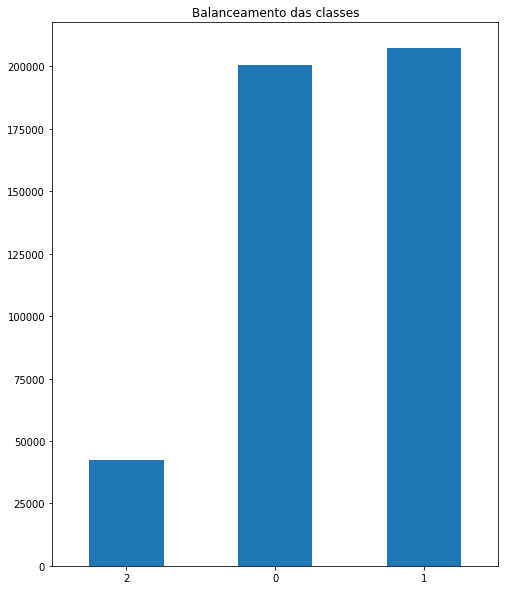

In [20]:
print(full_train_databset['label'].value_counts())

full_train_databset['label'].value_counts().sort_values().plot(kind = 'bar', figsize=(8,10), title="Balanceamento das classes", rot=0)

## **Transformando as classe Question em "Não é bug" IMPORTANTE!!!.**

Como mencionado, pretende-se trabalhar com apenas duas classes: "É bug" ou "Não é bug". ***É Bug*** será representados por 1 e ***Não é Bug*** representado por 0. 

**Perceba que bug é originalmente representado por 0. Sendo assim, pretende-se alterar essa classe 0 (do dataset oringinal) para 1 e as classes 1 e 2 para 0.**



In [21]:
df_bug_oringal =  full_train_databset[full_train_databset["label"] == 0]
df_not_bug_oringal =  full_train_databset[full_train_databset["label"] != 0]

print("***********************************")
print("df_bug_oringal:", df_bug_oringal.shape)
print("df_bug_oringal classes:", np.unique(df_bug_oringal.label))
print("df_not_bug_oringal:", df_not_bug_oringal.shape)
print("df_not_bug_oringal classes:", np.unique(df_not_bug_oringal.label))
print("***********************************")


df_bug_oringal.loc[:, ('label')] = 1
df_not_bug_oringal.loc[:, ('label')] = 0

print("df_bug_oringal classes:", np.unique(df_bug_oringal.label))
print("df_not_bug_oringal classes:", np.unique(df_not_bug_oringal.label))

full_train_databset = pd.concat([df_bug_oringal, df_not_bug_oringal])
df_bug_oringal = None
df_not_bug_oringal = None
full_train_databset.head()


***********************************
df_bug_oringal: (200481, 3)
df_bug_oringal classes: [0]
df_not_bug_oringal: (249519, 3)
df_not_bug_oringal classes: [1 2]
***********************************
df_bug_oringal classes: [1]
df_not_bug_oringal classes: [0]


,title,body,label
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1
5,script stopped adding video's,a recent change in the youtube layout broke th...,1
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1
15,filter floating points,background\r \r we have identified a small num...,1


## **Balancemento das classes após a transformação do dataset?**

Esse será o dataset final, então é importante sabe como ele está.

0    249519
1    200481
Name: label, dtype: int64


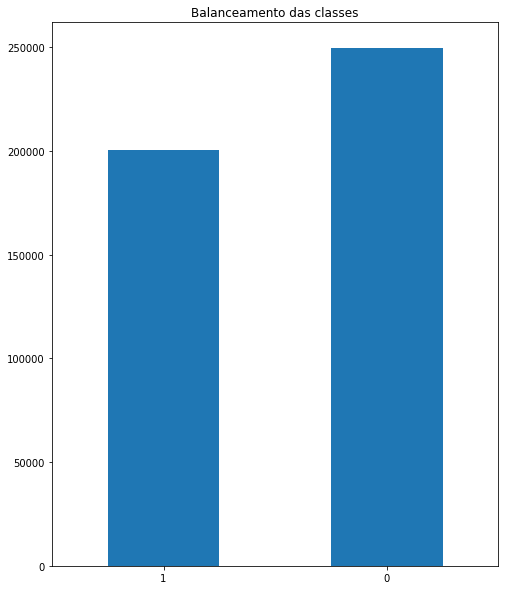

In [22]:
print(full_train_databset['label'].value_counts())

full_train_databset['label'].value_counts().sort_values().plot(kind = 'bar', figsize=(8,10), title="Balanceamento das classes", rot=0)

## **Concatenando Título e Body**

Como pode ser observado, tanto o título quanto o corpo contém informações que pode ser relevantes para a classificação. Portanto, pretende concatenar título e corpo em um único atributo. 

In [23]:
full_train_databset.head()

,title,body,label
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1
5,script stopped adding video's,a recent change in the youtube layout broke th...,1
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1
15,filter floating points,background\r \r we have identified a small num...,1


In [24]:
def concat_title_body(x):
    return x['title'] + " " + x['body']   

full_train_databset['title_body']= full_train_databset.apply(lambda x : concat_title_body(x),axis=1)
full_train_databset.head()

,title,body,label,title_body
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1,buggy behavior in selection ! screenshot from ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1,enable pid on / pid off alarm actions for ardu...
5,script stopped adding video's,a recent change in the youtube layout broke th...,1,script stopped adding video's a recent change ...
9,en la org ull-esit-pl-1617 people info /nico/ ...,\r crguezl>ull-esit-pl-1617> people info /nico...,1,en la org ull-esit-pl-1617 people info /nico/ ...
15,filter floating points,background\r \r we have identified a small num...,1,filter floating points background\r \r we have...


## **Induzindo classificador baseline**

Como tarefa final, pretend-se induzir um classificador que seja bom o suficiente para classificar issues em bug ou não. Para verificar se os classificadores são bons o suficiente, inicialmente busca-se induzir um classificador que irá servir como base de comparação para outros. Isso, todo classificador induzido deve ser melhor que esse baseline. 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [25]:
vectorizer = TfidfVectorizer()
df = vectorizer.fit_transform(full_train_databset['title_body'].values)

X_train, X_test, y_train, y_test = train_test_split(df, full_train_databset['label'].values, test_size=0.33, random_state=42)
df = None

In [26]:
#clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train) 

RandomForestClassifier(max_depth=2, random_state=0)

In [27]:
predicted = clf.predict(X_test)

In [28]:
print(metrics.classification_report(y_test, predicted,target_names=['Bug', 'Não Bug']))

              precision    recall  f1-score   support

         Bug       0.55      1.00      0.71     82363
     Não Bug       1.00      0.00      0.00     66137

    accuracy                           0.55    148500
   macro avg       0.78      0.50      0.36    148500
weighted avg       0.75      0.55      0.40    148500

